In [1]:
# Motor Vehicle Collisions - Crashes 1.67M rows
mvcollision = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv"

Traffic Collison Data

In [2]:
%run data.py

In [3]:
collison = fetchData(mvcollision)

In [4]:
type(collison)

pandas.core.frame.DataFrame

In [5]:
#get 2019.1.1 - today's data out
collison_url2 = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$select=crash_date,borough,zip_code,collision_id&$where=crash_date>'2019-01-01T00:00:00.000'&$limit=500000"

In [6]:
collison_19to20 = pd.read_csv(collison_url2)

In [7]:
collison_19to20.count()

crash_date      254299
borough         165120
zip_code        165071
collision_id    254299
dtype: int64

In [8]:
collison_19to20.head(2)

,crash_date,borough,zip_code,collision_id
0,2019-01-02T00:00:00.000,NaN,NaN,4061144
1,2019-01-02T00:00:00.000,NaN,NaN,4061198


In [9]:
collison_19to20.dtypes

crash_date       object
borough          object
zip_code        float64
collision_id      int64
dtype: object

In [10]:
collison_19to20['zip_code'].fillna(0, inplace=True)

In [11]:
#convert data type
collisonpd = collison_19to20.astype({"crash_date":'datetime64[ns]', "borough":str, "zip_code":int, "collision_id":int})

In [12]:
collison_df = spark.createDataFrame(collisonpd)

In [13]:
collison_df.printSchema()

root
 |-- crash_date: timestamp (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: long (nullable = true)
 |-- collision_id: long (nullable = true)



In [14]:
collison_df.count()

254299

In [15]:
collison_df.orderBy(collison_df.crash_date.desc()).show(10)

+-------------------+--------+--------+------------+
|         crash_date| borough|zip_code|collision_id|
+-------------------+--------+--------+------------+
|2020-05-02 00:00:00|     nan|       0|     4311464|
|2020-05-02 00:00:00|BROOKLYN|   11238|     4311571|
|2020-05-02 00:00:00|     nan|       0|     4311775|
|2020-05-02 00:00:00|     nan|       0|     4311316|
|2020-05-02 00:00:00|   BRONX|   10473|     4311633|
|2020-05-02 00:00:00|BROOKLYN|   11207|     4311460|
|2020-05-02 00:00:00|     nan|       0|     4311678|
|2020-05-02 00:00:00|   BRONX|   10451|     4311622|
|2020-05-02 00:00:00|BROOKLYN|   11238|     4311323|
|2020-05-02 00:00:00|   BRONX|   10462|     4311634|
+-------------------+--------+--------+------------+
only showing top 10 rows



In [16]:
collison_df.createOrReplaceTempView("collisonT")

In [17]:
collison_whole = spark.sql("""
SELECT DATE(crash_date) AS crash_date,
    COUNT(*) AS num_of_crash
FROM collisonT
GROUP BY crash_date
ORDER BY crash_date DESC
""")

In [18]:
collison_whole.show(3)

+----------+------------+
|crash_date|num_of_crash|
+----------+------------+
|2020-05-02|         140|
|2020-05-01|         155|
|2020-04-30|         150|
+----------+------------+
only showing top 3 rows



In [19]:
collison_wholepd = collison_whole.toPandas()

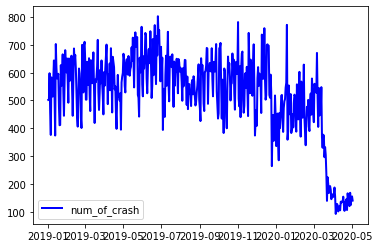

In [21]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot('crash_date','num_of_crash', data=collison_wholepd, marker='', color='blue', linewidth=2)
plt.legend()